<a href="https://colab.research.google.com/github/chandan2294/Hosuing_Prices_End_to_End_Machine_Learning_Project/blob/master/End_to_End_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.

**Setup**

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed, as well as Scikit-Learn >= 0.20

In [0]:
#Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

#Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

#Common imports
import numpy as np
import os

#To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

#Ignore useless warnings 
import warnings
warnings.filterwarnings(action = 'ignore', message = "^internal gelsd")

**Download the data**

In typical environments your data would be available in a relational database (or
some other common data store) and spread across multiple tables/documents/files.
To access it, you would first need to get your credentials and access authorizations10
and familiarize yourself with the data schema.

You could use your web browser to download the file and run tar xzf housing.tgz
to decompress it and extract the CSV file, but it is preferable to create a small function
to do that. Having a function that downloads the data is useful in particular if the
data changes regularly: you can write a small script that uses the function to fetch the
latest data (or you can set up a scheduled job to do that automatically at regular intervals).
Automating the process of fetching the data is also useful if you need to install
the dataset on multiple machines.

In [0]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path = housing_path)
  housing_tgz.close() 

Now when you call fetch_housing_data(), it creates a datasets/housing directory in
your workspace, downloads the housing.tgz file, and extracts the housing.csv file from
it in this directory.

In [0]:
fetch_housing_data()

In [0]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

In [0]:
housing = load_housing_data()

#Look at the data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [0]:
#Get a quick description of the data (in particular total number of rows, each attribute's type, and the number of nonnull values)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20640 instances in the dataset. Notice that the *total_bedrooms* attribute has only 20433 nonnull values, meaning that 207 districts are missing this feature.

All attributes are numerical, except the ocean_proximity field. Its type is object, so it
could hold any kind of Python object.

In [0]:
#What categories exist in ocean_proximity

housing['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [0]:
#How many districts belong to each category 
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [0]:
#Summary of the data
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are
ignored (so, for example, the count of total_bedrooms is 20,433, not 20,640). The
std row shows the standard deviation, which measures how dispersed the values are.12
The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates
the value below which a given percentage of observations in a group of observations
fall. For example, 25% of the districts have a housing_median_age lower than
18, while 50% are lower than 29 and 75% are lower than 37. These are often called the
25th percentile (or first quartile), the median, and the 75th percentile (or third
quartile).


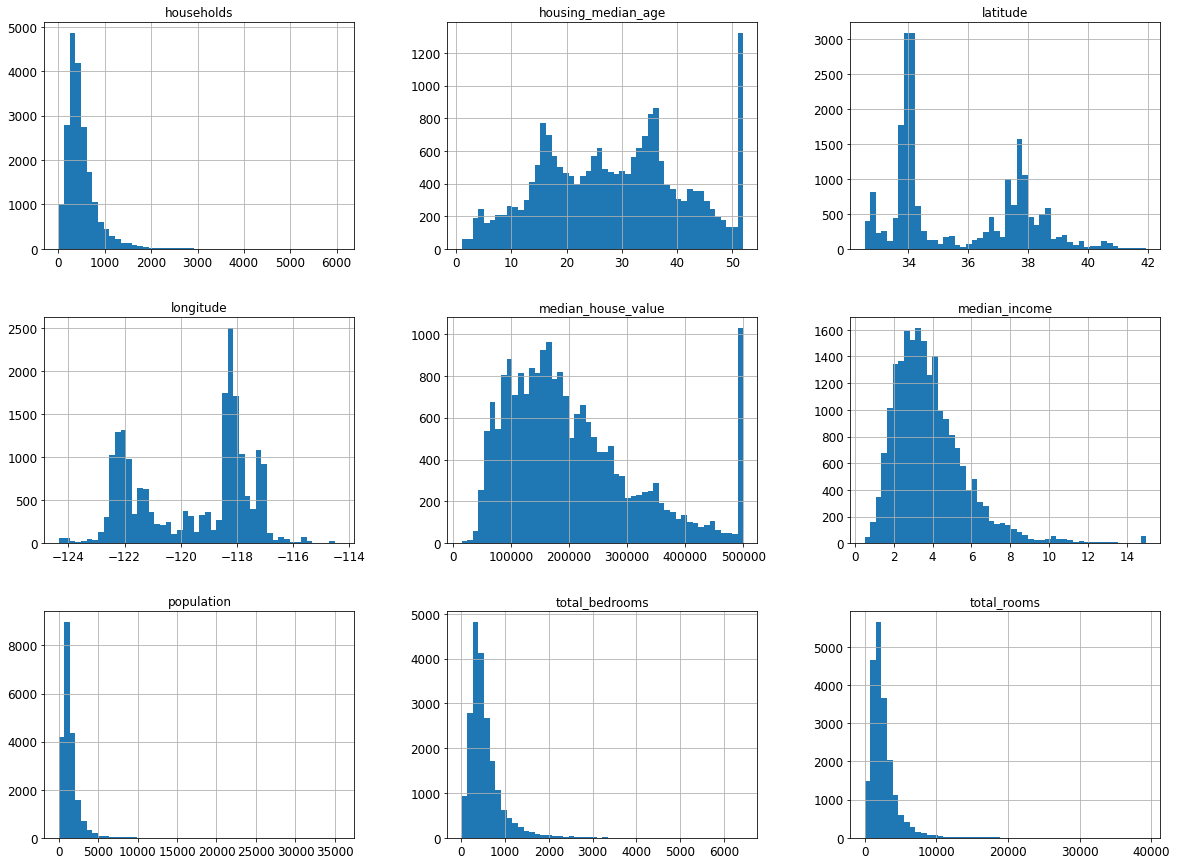

In [0]:
#Another quick way to get feel of data is by plotting histogram for each numerical attribute

%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize=(20,15))
plt.show()

In [0]:
#Set the random number generator seed

np.random.seed(45)

#Create a test set

def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [0]:
train_set, test_set = split_train_test(housing, 0.2)
print('Length of training set: ', len(train_set))
print('Length of testing set:', len(test_set))

Length of training set:  16512
Length of testing set: 4128


In [0]:
#Simple code of what's happening above
a = np.random.permutation(10)
print(a)
test = a[:3]
print(test)
train = a[3:]
print(train)

[4 2 9 8 3 1 6 0 7 5]
[4 2 9]
[8 3 1 6 0 7 5]


If the dataset is changed and you need to fetch an updated dataset, then to have a stable train/test split even after updating the dataset, a common solution is to
use each instance’s identifier to decide whether or not it should go in the test set
(assuming instances have a unique and immutable identifier). For example, you could
compute a hash of each instance’s identifier and put that instance in the test set if the
hash is lower than or equal to 20% of the maximum hash value. This ensures that the
test set will remain consistent across multiple runs, even if you refresh the dataset.
The new test set will contain 20% of the new instances, but it will not contain any
instance that was previously in the training set.



In [0]:
#Using Scikit learn

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

You may want to ensure that
the test set is representative of the various categories of incomes in the whole dataset.
Since the median income is a continuous numerical attribute, you first need to create
an income category attribute.

In [0]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


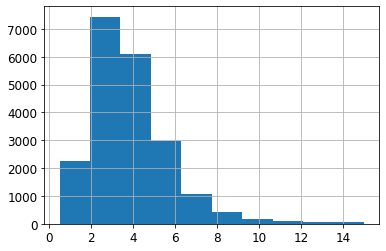

In [0]:
housing['median_income'].hist()

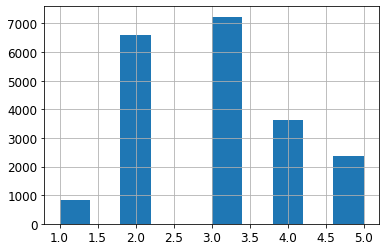

In [0]:
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels = [1, 2, 3, 4, 5])

housing['income_cat'].hist()

In [0]:
housing['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

Now you are ready to do stratified sampling based on the income category. For this
you can use Scikit-Learn’s *StratifiedShuffleSplit* class:

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [0]:
len(strat_train_set)

16512

In [0]:
len(strat_test_set)

4128

In [0]:
strat_test_set['income_cat'].value_counts()

3    1447
2    1316
4     728
5     473
1     164
Name: income_cat, dtype: int64

In [0]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [0]:
housing['income_cat'].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [0]:
def income_cat_proportions(data):
  return data['income_cat'].value_counts()/len(data)

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()
compare_props['Rand %Error'] = 100 * compare_props['Random']/compare_props['Overall'] - 100
compare_props['Strat %Error'] = 100 * compare_props['Stratified']/compare_props['Overall'] - 100

In [0]:
compare_props

,Overall,Stratified,Random,Rand %Error,Strat %Error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Now you should remove the income_cat attribute so the data is back to its original
state:

In [0]:
for set in (strat_train_set, strat_test_set):
  set.drop('income_cat', axis = 1, inplace = True)

In [0]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN


We spent quite a bit of time on test set generation for a good reason: this is an often
neglected but critical part of a Machine Learning project. Moreover, many of these
ideas will be useful later when we discuss cross-validation. Now it’s time to move on
to the next stage: exploring the data.

# **Discover and Visualize the Data to Gain Insights**

First, make sure you have put the test set aside and you are only exploring the training
set. Also, if the training set is very large, you may want to sample an exploration
set, to make manipulations easy and fast. In our case, the set is quite small, so you can
just work directly on the full set. Let’s create a copy so that you can play with it
without harming the training set:

In [0]:
housing = strat_train_set.copy()

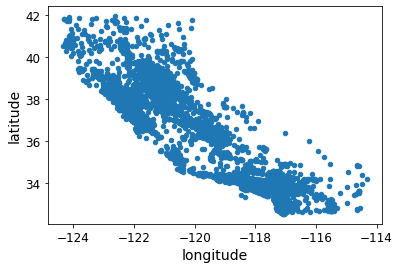

In [0]:
#Visualizing Geographical Data

housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude')

This looks like California all right, but other than that it is hard to see any particular
pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places
where there is a high density of data points

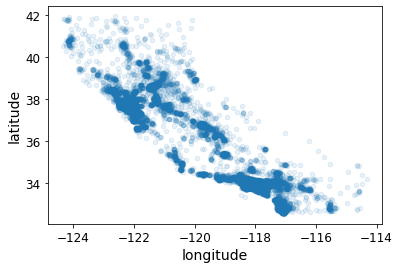

In [0]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)

Now let’s look at the housing prices. The radius of each circle represents
the district’s population (option s), and the color represents the price (option c). We
will use a predefined color map (option cmap) called jet, which ranges from blue
(low values) to red (high prices):

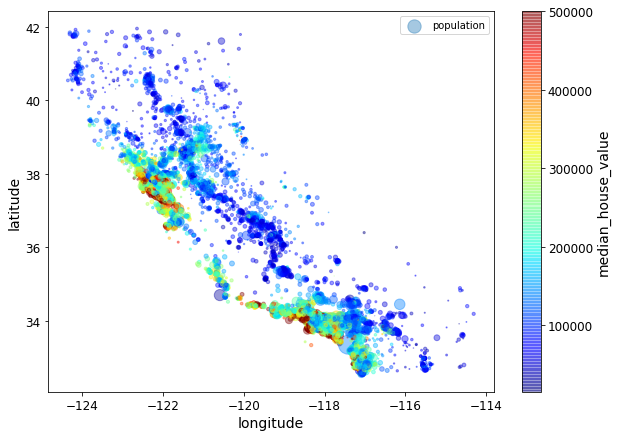

In [0]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4,
             s = housing['population']/100, label = 'population', figsize = (10,7),
             c = 'median_house_value', cmap = plt.get_cmap("jet"), colorbar = True, sharex = False)
plt.legend()

This image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density, as you probably knew already.
A clustering algorithm should be useful for detecting the main cluster and for adding
new features that measure the proximity to the cluster centers. The ocean proximity
attribute may be useful as well, although in Northern California the housing prices in
coastal districts are not too high, so it is not a simple rule.

**Correlations**

Since the data is not large, we can easily compute the standard correlation between every pair of attributes

In [0]:
corr_matrix = housing.corr()

#Now look at how much each attribute correlates with the median house value
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that
there is a strong positive correlation; for example, the median house value tends to go
up when the median income goes up. When the coefficient is close to –1, it means
that there is a strong negative correlation; you can see a small negative correlation
between the latitude and the median house value (i.e., prices have a slight tendency to
go down when you go north). Finally, coefficients close to 0 mean that there is no
linear correlation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f392f5a4240>,
      dtype=object)

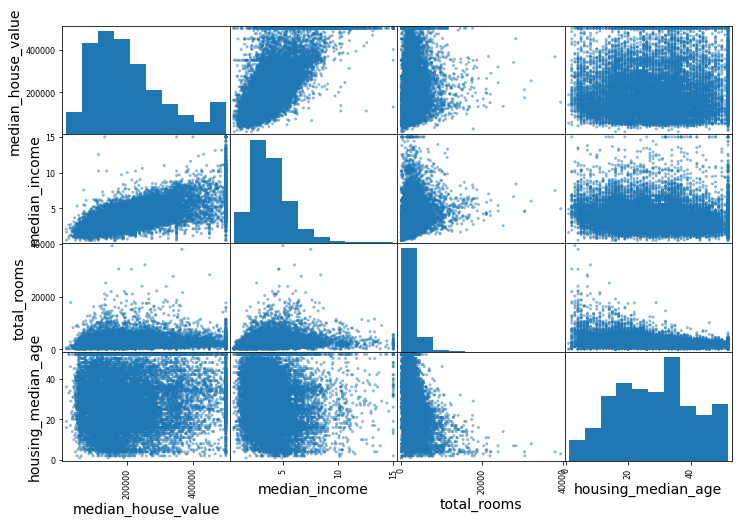

In [0]:
#Another way to check for correlation between attributes

from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 
              'housing_median_age']
scatter_matrix(housing[attributes], figsize = (12, 8))

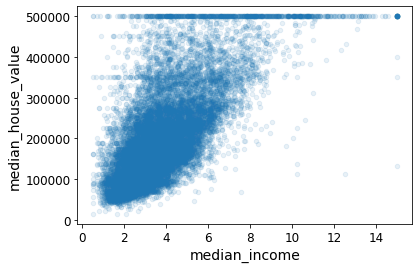

In [0]:
housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can
clearly see the upward trend, and the points are not too dispersed. Second, the price
cap that we noticed earlier is clearly visible as a horizontal line at \$500,000. But this
plot reveals other less obvious straight lines: a horizontal line around \$450,000,
another around \$350,000, perhaps one around \$280,000, and a few more below that.
You may want to try removing the corresponding districts to prevent your algorithms
from learning to reproduce these data quirks.

In [0]:
#Experimenting with Attribute Combinations

housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [0]:
#Now look at the correlation matrix
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# **Prepare the Data for Machine Learning Algorithms**

It’s time to prepare the data for your Machine Learning algorithms. Instead of doing
this manually, you should write functions for this purpose, for several good reasons:
* This will allow you to reproduce these 
transformations easily on any dataset (e.g.,
the next time you get a fresh dataset).
* You will gradually build a library of transformation functions that you can reuse
in future projects.
* You can use these functions in your live system to transform the new data before
feeding it to your algorithms.
* This will make it possible for you to easily try various transformations and see
which combination of transformations works best.


In [0]:
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

In [0]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [0]:
#Data Cleaning

sample_incomplete_rows = housing[housing.isnull().any(axis = 1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [0]:
#Option 1: Get rid of the corresponding districts

housing.dropna(subset = ['total_bedrooms'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [0]:
#Option 2: Get rid of the whole attribute
housing.drop('total_bedrooms', axis = 1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,1356.0,356.0,4.0625,<1H OCEAN


In [0]:
#Option 3: Set the values to some value (zero, mean, median, etc)
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace = True)

Scikit-Learn provides a handy class to take care of missing values: SimpleImputer.
Here is how to use it. First, you need to create a SimpleImputer instance, specifying
that you want to replace each attribute’s missing values with the median of that
attribute:

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

Since the median can only be computed on numerical attributes, you need to create a
copy of the data without the text attribute ocean_proximity:

In [0]:
housing_num = housing.drop("ocean_proximity", axis = 1)
#Alternatively: housing_num = housing.select_dtypes(include = [np.number])
#Now fit the imputer to the training data
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

The imputer has simply computed the median of each attribute and stored the result
in its statistics_ instance variable. Only the total_bedrooms attribute had missing
values, but we cannot be sure that there won’t be any missing values in new data after
the system goes live, so it is safer to apply the *imputer* to all the numerical attributes:

In [0]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [0]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now you can use this “trained” *imputer* to transform the training set by replacing
missing values with the learned medians:

In [0]:
X = imputer.transform(housing_num)

In [0]:
#Put it back into pandas dataframe
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

In [0]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [0]:
imputer.strategy

'median'

In [0]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


Now let's preprocess the categorical input feature, *ocean_proximity*

In [0]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Let's convert these categories from text to numbers. For this, we can use Scikit-Learn's *OrdinalEncoder* class:

In [0]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [0]:
#We can get the list of categories using the 'categories_' instance variable
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby
values are more similar than two distant values. This may be fine in some cases (e.g.,
for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously
not the case for the ocean_proximity column (for example, categories 0 and 4
are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category
is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category
is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding,
because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).
The new attributes are sometimes called dummy attributes. Scikit-Learn provides a
OneHotEncoder class to convert categorical values into one-hot vectors

In [0]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very
useful when you have categorical attributes with thousands of categories. After onehot
encoding, we get a matrix with thousands of columns, and the matrix is full of 0s
except for a single 1 per row. Using up tons of memory mostly to store zeros would
be very wasteful, so instead a sparse matrix only stores the location of the nonzero
elements. You can use it mostly like a normal 2D array,21 but if you really want to convert
it to a (dense) NumPy array, just call the toarray() method:

In [0]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [0]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**Custom Transformers**

In [0]:

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [0]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, 
                                     columns = list(housing.columns) + ['rooms_per_household', 'population_per_household'],
                                     index = housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


**Transformation Pipelines**

Scikit-Learn provides the Pipeline class to help with such sequences of transformations.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('attribs_adder', CombinedAttributesAdder()),
                          ('std_scaler', StandardScaler())])
                         
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [0]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [0]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
                                   ('num',num_pipeline, num_attribs),
                                   ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [0]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [0]:
housing_prepared.shape

(16512, 16)

# **Select and Train a Model**

You framed the problem, you got the data and explored it, you sampled a
training set and a test set, and you wrote transformation pipelines to clean up and
prepare your data for Machine Learning algorithms automatically. You are now ready
to select and train a Machine Learning model.

**Training and Evaluating on the Training Set**

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We now have a working Linear Regression model. Let's try it out on a few instances from the training set:


In [0]:
some_data = housing.iloc[:5]
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [0]:
some_labels = housing_labels[:5]
some_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [0]:
some_data_prepared = full_pipeline.transform(some_data)
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [0]:
print("Predictions: ", lin_reg.predict(some_data_prepared))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [0]:
print("Labels: ", list(some_labels))

Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works, although the predictions are not exactly accurate (e.g., the first prediction is
off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training
set using Scikit-Learn’s mean_squared_error() function:

In [0]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

This is better than nothing, but clearly not a great score: most districts’ median_hous
ing_values range between \$120,000 and \$265,000, so a typical prediction error of
$68,628 is not very satisfying. This is an example of a model underfitting the training
data. When this happens it can mean that the features do not provide enough
information to make good predictions, or that the model is not powerful enough



The main ways to fix underfitting are to select a more
powerful model, to feed the training algorithm with better features, or to reduce the
constraints on the model. This model is not regularized, which rules out the last
option. You could try to add more features (e.g., the log of the population), but first
let’s try a more complex model to see how it does.

In [0]:
#Let's train DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
#Model is trained, let's evaluate it on the training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course,
it is much more likely that the model has badly overfit the data. How can you be sure?
As we saw earlier, you don’t want to touch the test set until you are ready to launch a
model you are confident about, so you need to use part of the training set for training
and part of it for model validation.

# **Better Evaluation Using Cross-Validation**

One way to evaluate the Decision Tree model would be to use the
train_test_split() function to split the training set into a smaller training set and a
validation set, then train your models against the smaller training set and evaluate
them against the validation set. It’s a bit of work, but nothing too difficult, and it
would work fairly well.


A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The following
code randomly splits the training set into 10 distinct subsets called folds, then it
trains and evaluates the Decision Tree model 10 times, picking a different fold for
evaluation every time and training on the other 9 folds. The result is an array containing
the 10 evaluation scores:

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring = 'neg_mean_squared_error', cv = 10)
tree_rmse_scores = np.sqrt(-scores)

In [0]:
#Let's look at the results

def display_scores(scores):
  print("Scores: ", scores)
  print("Mean: ", scores.mean())
  print("Standard Deviation: ", scores.std())

display_scores(tree_rmse_scores)

Scores:  [70290.26585274 66633.07790238 72267.79106126 68737.56763429
 71337.05073234 74337.88478396 70598.30787307 70918.45330335
 76782.80451594 69604.39501825]
Mean:  71150.7598677584
Standard Deviation:  2699.7030570790525


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform
worse than the Linear Regression model! Notice that cross-validation allows
you to get not only an estimate of the performance of your model, but also a measure
of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a
score of approximately 71,407, generally ±2,439. You would not have this information
if you just used one validation set. But cross-validation comes at the cost of training
the model several times, so it is not always possible.

In [0]:
#Let's check the same for Linear Regression

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring = 'neg_mean_squared_error', cv = 10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard Deviation:  2731.674001798344


That’s right: the Decision Tree model is overfitting so badly that it performs worse
than the Linear Regression model.

In [0]:
#Let's look at the Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18649.743678202023

In [0]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                                scoring = 'neg_mean_squared_error', cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [49368.59735927 47590.91174472 49449.66221094 52390.2736243
 49498.65065691 53373.91558861 48925.7361543  48551.85968188
 53599.70827402 50023.708523  ]
Mean:  50277.3023817957
Standard Deviation:  1982.2704556694391


Wow, this is much better: Random Forests look very promising. However, note that
the score on the training set is still much lower than on the validation sets, meaning
that the model is still overfitting the training set. Possible solutions for overfitting are
to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.
Before you dive much deeper into Random Forests, however, you should try out
many other models from various categories of Machine Learning algorithms (e.g.,
several Support Vector Machines with different kernels, and possibly a neural network),
without spending too much time tweaking the hyperparameters. The goal is to
shortlist a few (two to five) promising models.

In [0]:
#Let's look at SVM 

from sklearn import svm
svm_reg = svm.SVR()
svm_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
svm_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, svm_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

118580.68301157995

In [0]:
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels, 
                             scoring = 'neg_mean_squared_error', cv = 10)
svm_rmse = np.sqrt(-svm_scores)
display_scores(svm_rmse)

Scores:  [111389.0681902  119541.25938571 116957.62830414 120447.19932481
 117618.15904234 122309.10351544 117634.40230741 121469.713921
 120343.01369623 118017.12860651]
Mean:  118572.66762937943
Standard Deviation:  2936.8775867949425


# **Fine Tune your model**

Let's assume that you now have a shortlist of promising models. You now need to fine tune them. Let's see how we can do that:

# **Grid Search**
One option would be to fiddle with the hyperparameters manually, until you find a
great combination of hyperparameter values. This would be very tedious work, and
you may not have time to explore many combinations.
Instead, you should get Scikit-Learn’s GridSearchCV to search for you. All you need
to do is tell it which hyperparameters you want it to experiment with and what values
to try out, and it will use cross-validation to evaluate all the possible combinations of
hyperparameter values. For example, the following code searches for the best combination
of hyperparameter values for the RandomForestRegressor:

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

This param_grid tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of
n_estimators and max_features hyperparameter values specified in the first dict, then try all 2 × 3 = 6 combinations of hyperparameter values in the
second dict, but this time with the bootstrap hyperparameter set to False instead of
True (which is the default value for this hyperparameter).


The grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor
hyperparameter values, and it will train each model 5 times (since we are using fivefold
cross validation). In other words, all in all, there will be 18 × 5 = 90 rounds of
training! It may take quite a long time, but when it is done you can get the best combination
of parameters like this:

In [0]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [0]:
#We can get best estimator like this:

grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
#Evaluation scores

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)

63016.94920778389 {'max_features': 2, 'n_estimators': 3}
55596.48658131985 {'max_features': 2, 'n_estimators': 10}
53095.35917396542 {'max_features': 2, 'n_estimators': 30}
61008.39854320642 {'max_features': 4, 'n_estimators': 3}
52704.54351076601 {'max_features': 4, 'n_estimators': 10}
50544.661622824075 {'max_features': 4, 'n_estimators': 30}
58317.91159817619 {'max_features': 6, 'n_estimators': 3}
52104.161605477326 {'max_features': 6, 'n_estimators': 10}
50054.30714222578 {'max_features': 6, 'n_estimators': 30}
58957.21537231978 {'max_features': 8, 'n_estimators': 3}
52121.01741131844 {'max_features': 8, 'n_estimators': 10}
49990.97045158665 {'max_features': 8, 'n_estimators': 30}
62975.05525847667 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54461.24753552145 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59879.98237334818 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52182.223143347495 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [0]:
pd.DataFrame(grid_search.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.074333,0.001740,0.004294,0.000083,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.726881e+09,-4.162931e+09,-4.019627e+09,-3.973695e+09,-3.972545e+09,-3.971136e+09,1.405742e+08,18,-1.088584e+09,-1.042938e+09,-1.081988e+09,-1.068211e+09,-1.080813e+09,-1.072507e+09,1.618731e+07
1,0.243982,0.007024,0.012289,0.000319,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.852594e+09,-3.270172e+09,-3.134591e+09,-2.942235e+09,-3.255254e+09,-3.090969e+09,1.673024e+08,11,-5.631944e+08,-6.033605e+08,-5.521876e+08,-5.672072e+08,-5.836524e+08,-5.739204e+08,1.785416e+07
2,0.725095,0.005960,0.033502,0.000648,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.650176e+09,-2.944368e+09,-2.984103e+09,-2.605209e+09,-2.911730e+09,-2.819117e+09,1.586081e+08,9,-4.310399e+08,-4.387768e+08,-4.319830e+08,-4.470036e+08,-4.294012e+08,-4.356409e+08,6.518086e+06
3,0.121026,0.002778,0.004395,0.000092,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.776508e+09,-4.022217e+09,-3.819984e+09,-3.283493e+09,-3.707921e+09,-3.722025e+09,2.429768e+08,16,-1.028831e+09,-1.023748e+09,-9.482318e+08,-9.277783e+08,-8.964908e+08,-9.650159e+08,5.269880e+07
4,0.396772,0.010767,0.012035,0.000493,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.628969e+09,-2.865887e+09,-3.057656e+09,-2.507493e+09,-2.828839e+09,-2.777769e+09,1.917812e+08,8,-5.192729e+08,-4.931506e+08,-5.220229e+08,-5.033699e+08,-5.147299e+08,-5.105093e+08,1.076544e+07
5,1.199713,0.011705,0.033106,0.000341,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.405233e+09,-2.695887e+09,-2.631023e+09,-2.355599e+09,-2.686072e+09,-2.554763e+09,1.449131e+08,3,-4.004589e+08,-4.012161e+08,-3.802230e+08,-3.938480e+08,-3.947899e+08,-3.941072e+08,7.539014e+06
6,0.166957,0.003830,0.004390,0.000163,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.294641e+09,-3.325249e+09,-3.513139e+09,-3.349599e+09,-3.522267e+09,-3.400979e+09,9.692610e+07,12,-8.980350e+08,-8.581651e+08,-9.609110e+08,-9.281582e+08,-9.449804e+08,-9.180499e+08,3.647271e+07
7,0.553873,0.002569,0.012032,0.000203,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.542315e+09,-2.752954e+09,-2.953445e+09,-2.577321e+09,-2.748183e+09,-2.714844e+09,1.470871e+08,5,-5.160197e+08,-5.033804e+08,-5.011891e+08,-5.169573e+08,-4.844679e+08,-5.044029e+08,1.184349e+07
8,1.655895,0.006316,0.033447,0.000489,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.403876e+09,-2.560882e+09,-2.609238e+09,-2.305775e+09,-2.647397e+09,-2.505434e+09,1.297543e+08,2,-4.067057e+08,-3.926174e+08,-3.876709e+08,-3.938092e+08,-3.834698e+08,-3.928546e+08,7.845585e+06
9,0.218123,0.002908,0.004399,0.000109,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.134296e+09,-3.602978e+09,-3.798047e+09,-3.394219e+09,-3.450227e+09,-3.475953e+09,2.208852e+08,14,-8.857976e+08,-8.851150e+08,-8.906599e+08,-8.987424e+08,-8.976108e+08,-8.915851e+08,5.722765e+06


In this example, we obtain the best solution by setting the max_features hyperparameter
to 8 and the n_estimators hyperparameter to 30. The RMSE score for this
combination is 49,682, which is slightly better than the score you got earlier using the
default hyperparameter values (which was 50,182). Congratulations, you have successfully
fine-tuned your best model!

# **Randomized Search**

The grid search approach is fine when you are exploring relatively few combinations,
like in the previous example, but when the hyperparameter search space is large, it is
often preferable to use RandomizedSearchCV instead. This class can be used in much
the same way as the GridSearchCV class, but instead of trying out all possible combinations,
it evaluates a given number of random combinations by selecting a random
value for each hyperparameter at every iteration. This approach has two main
benefits:
* If you let the randomized search run for, say, 1,000 iterations, this approach will
explore 1,000 different values for each hyperparameter (instead of just a few values
per hyperparameter with the grid search approach).
* Simply by setting the number of iterations, you have more control over the computing
budget you want to allocate to hyperparameter search.

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = [
              {'n_estimators': randint(low = 1, high = 200), 
               'n_jobs': randint(low = 1, high = 8), 
               'max_depth': randint(low = 1, high = 10),
               'max_features': randint(low = 1, high = 8)}
]

forest_reg = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(forest_reg, param_grid, cv = 5, n_iter=25, 
                                   scoring = 'neg_mean_squared_error', 
                                   return_train_score = True)
random_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
random_search.best_params_

{'max_depth': 9, 'max_features': 5, 'n_estimators': 129, 'n_jobs': 4}

In [0]:
random_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=129, n_jobs=4, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
random_search.best_score_

-2940220818.5598097

In [0]:
#Evaluation scores

cvres = random_search.cv_results_
for rank, mean_score, params in zip(cvres['rank_test_score'], cvres['mean_test_score'], cvres['params']):
  print(rank, np.sqrt(-mean_score), params)

7 60189.69637972913 {'max_depth': 6, 'max_features': 7, 'n_estimators': 133, 'n_jobs': 7}
6 60079.14695384508 {'max_depth': 6, 'max_features': 7, 'n_estimators': 191, 'n_jobs': 5}
10 63944.29975402433 {'max_depth': 5, 'max_features': 6, 'n_estimators': 106, 'n_jobs': 4}
25 99591.47744273636 {'max_depth': 1, 'max_features': 3, 'n_estimators': 34, 'n_jobs': 6}
24 96699.78342808518 {'max_depth': 1, 'max_features': 4, 'n_estimators': 23, 'n_jobs': 3}
19 74178.673184134 {'max_depth': 3, 'max_features': 5, 'n_estimators': 43, 'n_jobs': 4}
9 61942.700251705384 {'max_depth': 8, 'max_features': 2, 'n_estimators': 189, 'n_jobs': 2}
3 58281.14922144108 {'max_depth': 7, 'max_features': 5, 'n_estimators': 89, 'n_jobs': 2}
8 61170.89648542181 {'max_depth': 6, 'max_features': 5, 'n_estimators': 186, 'n_jobs': 3}
14 67451.23245351914 {'max_depth': 4, 'max_features': 7, 'n_estimators': 73, 'n_jobs': 5}
16 68010.57656730914 {'max_depth': 4, 'max_features': 6, 'n_estimators': 193, 'n_jobs': 2}
20 78345.4

**Analyze the Best Models and their Errors**

You will often gain good insights on the problem by inspecting the best models. For
example, the RandomForestRegressor can indicate the relative importance of each
attribute for making accurate predictions:

In [0]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.14251256e-02, 6.24283099e-02, 4.35553563e-02, 1.46432068e-02,
       1.42648024e-02, 1.46891898e-02, 1.44591422e-02, 3.70018144e-01,
       4.32605287e-02, 1.10500376e-01, 5.63715455e-02, 7.63617216e-03,
       1.67408499e-01, 7.46938056e-05, 3.76103391e-03, 5.50387418e-03])

In [0]:
#Let's display these importance scores next to their corresponding attribute names:

extra_attribs = ['rooms_per_hold', 'pop_per_hold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3700181438045684, 'median_income'),
 (0.16740849917462902, 'INLAND'),
 (0.11050037563920247, 'pop_per_hold'),
 (0.0714251256142453, 'longitude'),
 (0.062428309931400354, 'latitude'),
 (0.05637154550105346, 'bedrooms_per_room'),
 (0.043555356319822595, 'housing_median_age'),
 (0.04326052869582093, 'rooms_per_hold'),
 (0.014689189795814515, 'population'),
 (0.014643206808810049, 'total_rooms'),
 (0.014459142226453805, 'households'),
 (0.014264802433713013, 'total_bedrooms'),
 (0.007636172161428922, '<1H OCEAN'),
 (0.005503874176275525, 'NEAR OCEAN'),
 (0.003761033911199723, 'NEAR BAY'),
 (7.469380556199792e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features
(e.g., apparently only one ocean_proximity category is really useful, so you could try
dropping the others).
You should also look at the specific errors that your system makes, then try to understand
why it makes them and what could fix the problem (adding extra features or
getting rid of uninformative ones, cleaning up outliers, etc.).

**Evaluate your system on the Test Set**

After tweaking your models for a while, you eventually have a system that performs
sufficiently well. Now is the time to evaluate the final model on the test set. There is
nothing special about this process; just get the predictors and the labels from your
test set, run your full_pipeline to transform the data (call transform(), not
fit_transform()—you do not want to fit the test set!), and evaluate the final model
on the test set:

In [0]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48121.690977424645

In [0]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)))

array([46106.08489044, 50056.20062618])

We could compute the interval manually like this:


In [0]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence)/2, df = m - 1)
tmargin = tscore * squared_errors.std(ddof = 1)/np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(46106.08489044229, 50056.200626184174)

In [0]:
#Alternatively you can use z-scores rather than t-scores

zscore = stats.norm.ppf((1 + confidence)/2)
zmargin = zscore * squared_errors.std(ddof = 1)/np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(46106.68894076879, 50055.644236915585)

# **Exercises**

1. Try a Support Vector Machine regressor (sklearn.svm.SVR) with various hyperparameters,
such as kernel="linear" (with various values for the C hyperparameter)
or kernel="rbf" (with various values for the C and gamma
hyperparameters). Don’t worry about what these hyperparameters mean for now.
How does the best SVR predictor perform?

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'kernel': ['linear'],
               'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000]},
              {'kernel': ['rbf'],
               'C': [1, 3, 10, 30, 100, 300, 1000],
               'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3]}
]

svm_reg = svm.SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv = 5,
                           scoring = 'neg_mean_squared_error', verbose = 2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10, kernel=linear .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=10, kernel=linear, total=   9.9s
[CV] C=10, kernel=linear .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV] .............................. C=10, kernel=linear, total=  10.0s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   9.8s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   9.7s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   9.7s
[CV] C=30, kernel=linear .............................................
[CV] .............................. C=30, kernel=linear, total=   9.6s
[CV] C=30, kernel=linear .............................................
[CV] .............................. C=30, kernel=linear, total=   9.6s
[CV] C=30, kernel=linear .............................................
[CV] .............................. C=30, kernel=linear, total=  10.0s
[CV] C=30, kernel=linear .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 65.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000],
                          'kernel': ['linear']},
                         {'C': [1, 3, 10, 30, 100, 300, 1000],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [0]:
#Best model achieves the following score:

negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.84006944533

That's worse than the *RandomForestRegressor*. Let's check the best hyperparameters found:

In [0]:
grid_search.best_params_

{'C': 30000, 'kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of C is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for C (removing the smallest values), because it is likely that higher values of C will be better.

2. Try replacing *GridSearchCV* with *RandomizedSearchCV*

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

#Note: gamma is ignored when kernel is "linear"
param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale = 1.0)
}

svm_reg = svm.SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs, 
                                n_iter = 50, scoring = 'neg_mean_squared_error',
                                cv = 5, verbose = 2, random_state = 42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.7s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.0s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.9s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.1s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.6s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.4s
[CV] C=26290.2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 99.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3924c65be0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f392555d6d8>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [0]:
negative_mse = rnd_search.best_score_
negative_rmse = np.sqrt(-negative_mse)
rmse

70363.84006944533

Now this is much closer to the performance of the *RandomForestRegressor* (but not quite there yet). Let's check the hyperparameters found:

In [0]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with scale=1.0. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

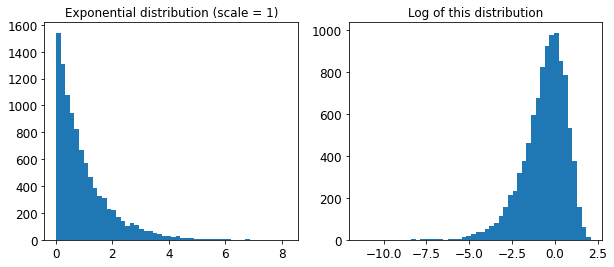

In [0]:
expon_distrib = expon(scale = 1)
samples = expon_distrib.rvs(10000, random_state = 42)
plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale = 1)")
plt.hist(samples, bins = 50)
plt.subplot(122)
plt.title('Log of this distribution')
plt.hist(np.log(samples), bins = 50)
plt.show()

The distribution we used for C looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

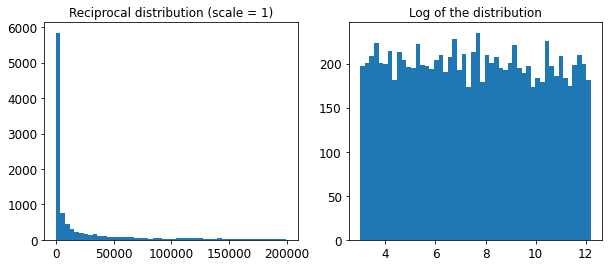

In [0]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state = 42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title('Reciprocal distribution (scale = 1)')
plt.hist(samples, bins = 50)
plt.subplot(122)
plt.title("Log of the distribution")
plt.hist(np.log(samples), bins = 50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

3. Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
  return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
  def __init__(self, feature_importances, k):
    self.feature_importances = feature_importances
    self.k = k
  def fit(self, X, y = None):
    self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
    return self
  def transform(self, X):
    return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a RandomForestRegressor). You may be tempted to compute them directly in the TopFeatureSelector's fit() method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [0]:
k = 5

In [0]:
#Now let's look for the indices of the top k features:

top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [0]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hold', 'INLAND'],
      dtype='<U18')

In [0]:
#Let's double check that these are indeed the top k features:
sorted(zip(feature_importances, attributes), reverse = True)[:k]

[(0.3700181438045684, 'median_income'),
 (0.16740849917462902, 'INLAND'),
 (0.11050037563920247, 'pop_per_hold'),
 (0.0714251256142453, 'longitude'),
 (0.062428309931400354, 'latitude')]

Looks good! Let's create a new pipeline that runs the previously defined prepared pipeline, and adds top k feature selection

In [0]:
preparation_and_feature_selection_pipeline = Pipeline([
                                                       ('preparation', full_pipeline),
                                                       ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [0]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [0]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [0]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Works great!

4. Try creating a single pipeline that does the full data preparation plus the final prediction.

In [0]:
prepare_select_and_predict_pipeline = Pipeline([
                                                ('preparation', full_pipeline),
                                                ('feature_selection', TopFeatureSelector(feature_importances, k)),
                                                ('svm_reg', svm.SVR(**rnd_search.best_params_))
])

In [0]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

In [0]:
#Let's try pipeline on a few instances
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best RandomForestRegressor that we found earlier, rather than the best SVR.

5. Automatically explore some preparation options using GridSearchCV.

In [0]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  12.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  12.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

KeyboardInterrupt: ignored

In [0]:
grid_search_prep.best_params_